#### 相關內容與工具

In [ ]:
### NLP Data Augmentation 常見方法
### https://marssu.coderbridge.io/2020/10/26/nlp-data-augmenatation-%E5%B8%B8%E8%A6%8B%E6%96%B9%E6%B3%95/

### [机器翻译] multilingual fairseq-preprocess的两种做法
### https://blog.csdn.net/jokerxsy/article/details/125054739

### (ML) Seq2seq -> Attention -> Self-attention -> Transformer
### https://medium.com/@jasonyen1009/ml-seq2seq-attention-self-attention-transformer-1b9134204d84

### Understanding incremental decoding in fairseq
### https://www.telesens.co/2019/04/21/understanding-incremental-decoding-in-fairseq/

### Incremental Decoding
### https://thinkwee.top/2020/03/17/incremental-decoding/

### 一文看懂ASCII,UNICODE,UTF8编码规则
### https://zhuanlan.zhihu.com/p/475820456

### Fairseq 机器翻译全流程一文速通 (NMT, WMT, translation)
### https://www.cnblogs.com/ysngki/p/17814160.html

### LLM大模型之基于SentencePiece扩充LLaMa中文词表实践
### https://zhuanlan.zhihu.com/p/655281268

### 大模型中的分词器tokenizer：BPE、WordPiece、Unigram LM、SentencePiece
### https://zhuanlan.zhihu.com/p/620508648

### Fairseq系列(1): pytorch如何处理不定长文本？ Dynamic Batch Size
### https://zhuanlan.zhihu.com/p/100135945

#### import套件

In [1]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

from torch.utils.data import Dataset, DataLoader
#from torch.utils.data import Sampler, RandomSampler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

2024-05-21 12:53:43 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [2]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')

2024-05-21 12:53:43 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2024-05-21 12:53:43 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 12.000 GB ; name = NVIDIA GeForce RTX 3060                 
2024-05-21 12:53:43 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


#### data路徑設置

In [3]:
data_dir = './data'

src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{data_dir}/raw'
test_prefix = f'{data_dir}/test'

In [4]:
dataset_name = 'ted2020'

prefix = Path(data_dir).absolute() / dataset_name

#### 檢視文本內容

In [5]:
with open(f'./data/valid.clean.zh', 'r', encoding='UTF-8') as f:
    for i in range(5):
        print(f.readline())

在我們的現代國家裡 , 邏輯和辯解的角色不再包括斡旋在財富和權力之間了 。

這個結構提出蘑菇體對於 「 行者 」 的決策起著一定的作用

15歲

另外 , 深入社區去拜訪了解鄰居買些甚麼食物從哪裡買還有為什麼買這些都是學生的回家作業

松嶺地區的肺結核患病率大約比全國平均患病率高八倍 。



In [6]:
with open(f'./data/valid.clean.en', 'r', encoding='UTF-8') as f:
    for i in range(5):
        print(f.readline())

And in our modern country , the role of logic and reason no longer includes mediating between wealth and power the way it once did .

So this anatomy suggests that the mushroom bodies have something to do with action choice .

She is 15 years old .

And going out into the community and interviewing your neighbors about what kind of food they buy and from where and why that's a homework assignment .

The tuberculosis rate on Pine Ridge is approximately eight times higher than the US national average .



In [7]:
with open(f'./data/train.clean.en', 'r', encoding='UTF-8') as f:
    for i in range(5):
        print(f.readline())

Thank you so much , Chris .

And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .

I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .

And I say that sincerely , partly because I need that .

Put yourselves in my position .



#### randm seed固定

In [8]:
seed = 33
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#### 以sentencepiece進行分詞
使用subword分詞(若以word分詞，單字量極多且一點小變化就會被當作不同的word；以字母char分詞，無法顧及語義)  
我們選擇將中英文丟入同一個model分詞，因此這個model處理兩種語言的encode,decode(只用單一model為fairseq採用的作法，若想分成不同model也可)

In [9]:
import sentencepiece as spm
vocab_size = 8000
if (Path(f'./newmodel/spm{vocab_size}.model')).exists():
    print(f'./newmodel/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{data_dir}/train.clean.{src_lang}',
                        f'{data_dir}/valid.clean.{src_lang}',
                        f'{data_dir}/train.clean.{tgt_lang}',
                        f'{data_dir}/valid.clean.{tgt_lang}']),
        model_prefix=Path(f'./newmodel/spm{vocab_size}'),
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
        pad_id=3
    )

./newmodel/spm8000.model exists. skipping spm_train.


#### 檢視分詞後編碼(encode)結果

In [10]:
import sentencepiece as spm
vocab_size = 8000

#spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
spm_model = spm.SentencePieceProcessor(model_file=str(Path(f'./newmodel/spm{vocab_size}.model')))

In [11]:
with open(f'./data/train.clean.en', 'r', encoding='UTF-8') as f:
    #for line in in_f:
    for i in range(5):
        line=f.readline()
        tok = spm_model.encode_as_ids(line)
        print(tok)

[553, 23, 34, 327, 4, 2730, 7]
[11, 20, 14, 6, 5, 19, 497, 46, 13, 548, 443, 41, 113, 12, 55, 9, 2828, 12, 329, 12, 29, 2892, 5, 19, 2031, 220, 293, 18, 14, 40, 2869, 46, 612, 221, 694, 7]
[18, 55, 261, 5, 1215, 659, 41, 1076, 125, 29, 319, 206, 57, 657, 4, 11, 18, 246, 12, 553, 77, 15, 23, 39, 9, 341, 5, 730, 220, 5, 483, 299, 6, 72, 61, 18, 149, 12, 291, 9, 199, 1823, 7]
[11, 18, 291, 16, 1731, 30, 46, 4, 466, 46, 133, 18, 248, 16, 7]
[519, 146, 6, 278, 99, 6, 17, 74, 540, 6, 1143, 7]


In [12]:
with open(f'./data/train.clean.zh', 'r', encoding='UTF-8') as f:
    #for line in in_f:
    for i in range(5):
        line=f.readline()
        tok = spm_model.encode_as_ids(line)
        print(tok)

[5, 252, 3389, 3389, 71, 4, 5, 515, 1018, 359, 10, 5, 101, 38, 131, 1166, 1290, 426, 3284, 64, 131, 2172, 1062]
[5, 716, 26, 53, 68, 3141, 2058, 10, 35, 252, 512, 1407, 10]
[608, 3225, 2976, 58, 2549, 1259, 168, 33, 711, 163, 724, 1493, 8, 1876, 1069, 4, 794, 512, 3389, 568, 102, 37, 1242, 2172, 8, 110, 2113, 10]
[35, 2458, 4132, 8, 181, 1090, 78, 4, 511, 2042, 1168, 1209, 37, 475, 38, 259, 308]
[5, 1038, 413, 1363, 452, 472, 117, 163, 1679, 53, 181, 308]


#### 幫分詞編碼結果加入代表開頭和結尾的bos和eos並檢視
編碼分別為1和2

In [13]:
def startend(toknum):
    toknum.insert(0,1)
    toknum.append(2)
    return toknum

In [14]:
with open(f'./data/train.clean.en', 'r', encoding='UTF-8') as f:
    #for line in in_f:
    for i in range(5):
        line=f.readline()
        tok = spm_model.encode(line, out_type=str)
        tok = startend(tok)
        print(tok)

[1, '▁thank', '▁you', '▁so', '▁much', '▁,', '▁chris', '▁.', 2]
[1, '▁and', '▁it', "'", 's', '▁', 't', 'ru', 'ly', '▁a', '▁great', '▁ho', 'n', 'or', '▁to', '▁have', '▁the', '▁opportunity', '▁to', '▁come', '▁to', '▁this', '▁stage', '▁', 't', 'wi', 'ce', '▁;', '▁i', "'", 'm', '▁extreme', 'ly', '▁gr', 'ate', 'ful', '▁.', 2]
[1, '▁i', '▁have', '▁been', '▁', 'bl', 'ow', 'n', '▁away', '▁by', '▁this', '▁con', 'f', 'er', 'ence', '▁,', '▁and', '▁i', '▁want', '▁to', '▁thank', '▁all', '▁of', '▁you', '▁for', '▁the', '▁many', '▁', 'ni', 'ce', '▁', 'com', 'ment', 's', '▁about', '▁what', '▁i', '▁had', '▁to', '▁say', '▁the', '▁other', '▁night', '▁.', 2]
[1, '▁and', '▁i', '▁say', '▁that', '▁since', 're', 'ly', '▁,', '▁part', 'ly', '▁because', '▁i', '▁need', '▁that', '▁.', 2]
[1, '▁put', '▁your', 's', 'el', 've', 's', '▁in', '▁my', '▁po', 's', 'ition', '▁.', 2]


In [15]:
with open(f'./data/train.clean.en', 'r', encoding='UTF-8') as f:
    #for line in in_f:
    for i in range(5):
        line=f.readline()
        tok = spm_model.encode_as_ids(line)
        tok = startend(tok)
        print(tok)

[1, 553, 23, 34, 327, 4, 2730, 7, 2]
[1, 11, 20, 14, 6, 5, 19, 497, 46, 13, 548, 443, 41, 113, 12, 55, 9, 2828, 12, 329, 12, 29, 2892, 5, 19, 2031, 220, 293, 18, 14, 40, 2869, 46, 612, 221, 694, 7, 2]
[1, 18, 55, 261, 5, 1215, 659, 41, 1076, 125, 29, 319, 206, 57, 657, 4, 11, 18, 246, 12, 553, 77, 15, 23, 39, 9, 341, 5, 730, 220, 5, 483, 299, 6, 72, 61, 18, 149, 12, 291, 9, 199, 1823, 7, 2]
[1, 11, 18, 291, 16, 1731, 30, 46, 4, 466, 46, 133, 18, 248, 16, 7, 2]
[1, 519, 146, 6, 278, 99, 6, 17, 74, 540, 6, 1143, 7, 2]


In [16]:
with open(f'./data/train.clean.zh', 'r', encoding='UTF-8') as f:
    #for line in in_f:
    for i in range(5):
        line=f.readline()
        tok = spm_model.encode(line, out_type=str)
        tok = startend(tok)
        print(tok)

[1, '▁', '非常', '謝', '謝', '你', '▁,', '▁', '克', '里', '斯', '▁。', '▁', '能', '有', '這個', '機會', '第二', '度', '踏', '上', '這個', '演講', '台', 2]
[1, '▁', '真', '是', '一', '大', '榮', '幸', '▁。', '▁我', '非常', '感', '激', '▁。', 2]
[1, '▁這個', '研', '討', '會', '給我', '留', '下', '了', '極', '為', '深', '刻', '的', '印', '象', '▁,', '▁我想', '感', '謝', '大家', '對', '我', '之前', '演講', '的', '好', '評', '▁。', 2]
[1, '▁我', '是由', '衷', '的', '想', '這麼', '說', '▁,', '▁有', '部份', '原因', '是因為', '我', '真的', '有', '需要', '▁!', 2]
[1, '▁', '請', '你們', '設', '身', '處', '地', '為', '我想', '一', '想', '▁!', 2]


In [17]:
with open(f'./data/train.clean.zh', 'r', encoding='UTF-8') as f:
    #for line in in_f:
    for i in range(5):
        line=f.readline()
        tok = spm_model.encode_as_ids(line)
        tok = startend(tok)
        print(tok)

[1, 5, 252, 3389, 3389, 71, 4, 5, 515, 1018, 359, 10, 5, 101, 38, 131, 1166, 1290, 426, 3284, 64, 131, 2172, 1062, 2]
[1, 5, 716, 26, 53, 68, 3141, 2058, 10, 35, 252, 512, 1407, 10, 2]
[1, 608, 3225, 2976, 58, 2549, 1259, 168, 33, 711, 163, 724, 1493, 8, 1876, 1069, 4, 794, 512, 3389, 568, 102, 37, 1242, 2172, 8, 110, 2113, 10, 2]
[1, 35, 2458, 4132, 8, 181, 1090, 78, 4, 511, 2042, 1168, 1209, 37, 475, 38, 259, 308, 2]
[1, 5, 1038, 413, 1363, 452, 472, 117, 163, 1679, 53, 181, 308, 2]


#### 將編碼和做成dataset的流程寫成class和function
* tokenINDEX: 將已編碼的資料一對一對應、進行長度padding，將src(輸入), prev(teacher forcing使用), tgt(目標)組成一筆資料
* get_dataset: 將輸入和目標兩種語言的資料進行編碼(含bos和eos)，並且只選取指定長度以內的資料，輸入tokenINDEX，取得dataset

透過這兩步取得dataset

In [18]:
class tokenINDEX(Dataset):
    def __init__(self, src_line, tgt_line, maxlength, padding_idx=3):
        self.src_line = src_line
        self.tgt_line = tgt_line
        self.maxlength = maxlength
        self.padding_idx = padding_idx
        
    def __getitem__(self,idx):
        src = self.src_line[idx]
        tgt = self.tgt_line[idx]
        src = src+[self.padding_idx] * (self.maxlength - len(src))  #src [1,..., 2, 3,...3]
        
        tgt = tgt+[self.padding_idx] * (self.maxlength - len(tgt))  #tgt [..., 2, 3,..3]
        prev = [1]+ tgt                                          #prev [1,....2, 3...3]
        tgt = tgt + [self.padding_idx]                            #tgt [....2,3,.....3]
        
        return torch.as_tensor(src), torch.as_tensor(prev), torch.as_tensor(tgt)
        
    def __len__(self):
        return len(self.src_line)

In [19]:
def get_dataset(src_root, tgt_root, spm_model, maxlength):
    src_line=[]
    tgt_line=[]
    #src_max=0
    #tgt_max=0
    
    with open(f'{src_root}', 'r', encoding='UTF-8') as f:
        for line in f:
            tok = spm_model.encode_as_ids(line)
            tok = startend(tok)
            src_line.append(tok)
            #src_max = max(src_max, len(tok))
    f.close()
    
    with open(f'{tgt_root}', 'r', encoding='UTF-8') as f:
        for line in f:
            tok = spm_model.encode_as_ids(line)
            tok = tok+[2]
            tgt_line.append(tok)
            #tgt_max = max(tgt_max, len(tok))
    f.close()
    
    assert len(src_line) == len(tgt_line)
    
    src_filter=[]
    tgt_filter=[]
    for i in range(len(src_line)):
        if len(src_line[i]) <= maxlength and len(tgt_line[i]) <= maxlength-1:
            src_filter.append(src_line[i])
            tgt_filter.append(tgt_line[i])
    
    
    assert len(src_filter) == len(tgt_filter)
    
    del src_line, tgt_line
    
    dataset = tokenINDEX(src_filter, tgt_filter, maxlength)
    return dataset

#### 作成train_dataset和valid_dataset並檢視

In [20]:
dataset=get_dataset('./data/train.clean.en',  './data/train.clean.zh', spm_model, 20)

In [21]:
dataset[0]

(tensor([   1,   11,   18,  291,   16, 1731,   30,   46,    4,  466,   46,  133,
           18,  248,   16,    7,    2,    3,    3,    3]),
 tensor([   1,   35, 2458, 4132,    8,  181, 1090,   78,    4,  511, 2042, 1168,
         1209,   37,  475,   38,  259,  308,    2,    3,    3]),
 tensor([  35, 2458, 4132,    8,  181, 1090,   78,    4,  511, 2042, 1168, 1209,
           37,  475,   38,  259,  308,    2,    3,    3,    3]))

In [22]:
valid_dataset=get_dataset('./data/valid.clean.en',  './data/valid.clean.zh', spm_model, 20)

In [23]:
valid_dataset[0]

(tensor([   1,  235,   24,    5, 1134,  244,  974,    7,    2,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3]),
 tensor([   1,    5, 1134,  773,    2,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3]),
 tensor([   5, 1134,  773,    2,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3]))

### Model組成

#### Encoder
大致步驟可理解為:
1. 將輸入編碼經過embedding
2. 輸入GRU，得到output和內部累積了整段時間資訊的final hidden layer
3. 紀錄padding位置的mask(padding部分後續不需要訓練和計算gradient)

輸出output, hidden, mask

In [24]:
class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, drop=0.3, padding_idx=3):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_idx = padding_idx
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=self.padding_idx)

        self.dropout_in_module = nn.Dropout(drop)
        self.rnn = nn.GRU(
            self.embedding_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=drop,
            batch_first=False,
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(drop)


    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()

        # get embeddings
        x = self.embedding(src_tokens) # Batch * Token -> Batch * Token * embed_Channel
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]

        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]

        encoder_padding_mask = src_tokens.eq(self.padding_idx).t() #find pad (for true), transpose
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )

    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

#### Attention
輸入(經過embed)的prev_token作為input，以及encoder的output和mask後，大致步驟可理解為:
1. input經過linear layer，變成與encoder的output相符的dimention(linear layer用來訓練找出input和encoder的output的關係性)
2. attention計算，將1與encoder的output矩陣相乘，得到attention score
3. 將attention score中mask的部分數值變成-inf
4. 對attention取softmax，使其成為分布在0~1的權重機率，再與encoder的output矩陣相乘(得出現在的翻譯該專注於encoder的output的哪部分)
5. 將4的weighted sum結果與input作concat，經過linear layer將兩者資訊結合在固定的dimention中，經過tanh activation(可防止後續輸入GRU的值不會過大，encoder時輸入的是經過embed的值，decoder接續使用encoder的hidden layer的話，理論上會希望輸入範圍不要差距過大)

輸出x(5的結果), attention score

In [25]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B

        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S

        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh

        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

#### Decoder
從encoder接收資料後，大致步驟可理解為:
1. 將prev_output_token作embedding(在train和valid和valid時採teacher forcing，可直接拿ground truth上一個token，因此可以平行運作，test時則須拿上一個decoder預測的output)
2. 將embed結果、encoder output、encoder mask輸入Attention function，得到經過attention的資訊及attention score
3. 將從encoder取得的final hidden layer作為decoder GRU的初始hidden layer(unidirection)，輸入經過attention的資訊，得到機器的翻譯結果
4. 將3得到的每個token結果透過linear layer轉成vocab_size大小，除了方便跟target作loss比對，也使我們能用sentencepiece轉回人類語言

輸出x(decode的結果), attention score

In [26]:
class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, drop=0.3, padding_idx=3, share_decoder_input_output_embed=True):
        super().__init__()

  #      assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder
  #      and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
  #      assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires
  #      that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_idx = padding_idx
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=self.padding_idx)

        self.dropout_in_module = nn.Dropout(drop)
        self.rnn = nn.GRU(
            self.embedding_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=drop,
            batch_first=False,
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embedding_dim, self.hidden_dim, self.embedding_dim, bias=False
        )
        # self.attention = None
        self.dropout_out_module = nn.Dropout(drop)

        if self.hidden_dim != self.embedding_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embedding_dim)
        else:
            self.project_out_dim = None

        if share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embedding.weight.shape[1],
                self.embedding.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embedding.weight
        else:
            self.output_projection = nn.Linear(
                self.embedding_dim, self.vocab_size, bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.embedding_dim ** -0.5
            )

    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch

        
        # incremental state does not exist, either this is training time, or the first timestep of test time
        # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
        prev_hiddens = encoder_hiddens

        bsz, seqlen = prev_output_tokens.size()

        # embed tokens
        x = self.embedding(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)

        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)

        # project to embedding size (if hidden differs from embed size, and share_embedding is True,
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)

        # project to vocab size
        x = self.output_projection(x)

        # T x B x C -> B x T x C
        x = x.transpose(1, 0)

        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        ###self.set_incremental_state(incremental_state, "cached_state", cache_state)

        #return x, None
        return x, attn

    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

#### 建model function 
負責宣告encoder, decoder並初始化模型內部參數

In [27]:
def build_model(vocab_size, embedding_dim, hidden_dim):    
    
    encoder = RNNEncoder(vocab_size, embedding_dim, hidden_dim, num_layers=1, drop=0.3, padding_idx=3).to(device)
    decoder = RNNDecoder(vocab_size, embedding_dim, hidden_dim*2, num_layers=1, drop=0.3, padding_idx=3, share_decoder_input_output_embed=True).to(device)
    
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
                    
    # weight initialization
    encoder.apply(init_params)
    decoder.apply(init_params)
    
    return encoder, decoder

#### Loss計算
* nll_loss: 計算與target相同index的loss(表示預測結果在正解的位置的loss，希望越小越好) (lprobs範圍在負無限~0)
* smooth_loss: 保留其他label也合理的可能性，因此將其他label的loss以較小比例納入考量 (產生gradient)

In [28]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce

    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy,
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=3,
)

#### 建立model

In [29]:
encoder, decoder = build_model(8000, 256, 512)

D:\anaconda_env\envs\gpu_env\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### 設定optimizer及learning rate
* warmup: learning rate從0開始向上提升，以減少初期的震盪
* decay(Inverse square root): 後期趨於穩定，learning rate往下降到一個較低的數值

In [30]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    #lr = 0.001
    lr = 1/d_model**0.5 * min(1/step_num**0.5, step_num*1/warmup_step**1.5)
    return lr

In [31]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

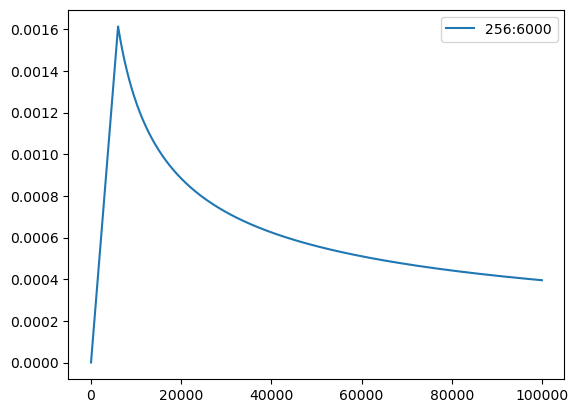

In [32]:
optimizer = NoamOpt(
    model_size=256, 
    factor=2., 
    #warmup=4000, 
    #factor=4., 
    warmup=6000, 
    optimizer=torch.optim.AdamW(list(encoder.parameters())+list(decoder.parameters()), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

#### 設定batch size和epoch數

In [33]:
batch_size=256
n_epoch=100

#### 建立調用dataset的dataloader

In [34]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [35]:
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)

#### 建立validation方式
validation除了觀察loss以外，也應評比人類語言角度上的好壞，採用BLEU，比較方法可看成是語句間透過sliding window得到的片段的相似度

sacrebleu套件的corpus_bleu可比較兩個語料庫(許多句子)的相似度

我們會把每句的tokens經過sentencepiece model decode後，合在一個string中，形成一個句子，各自append到hyps(預測)和refs(目標)，最後比較兩個list

refs內可有多組參考語料庫(正解不只一組)，評比時會以句子為單位，找出refs中與hyps評分最高的一組作為此句的正解，每句都如此操作。
>如: refs 有 r1, r2兩個語料庫， 要與 hyp 評比 ha, hb 兩句話。 若ha評比時: r1a>r2a, hb評比時: r2b>r1b， 最後BLEU評分會以(r1a, r2b)為參考

In [36]:
import sacrebleu

def validate(encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    hyps = []
    refs = []
    hyps_code = []
    refs_code = []
    with torch.no_grad():
        stats = {"loss":[], "bleu": 0}
        for i, data in enumerate(valid_dataloader):
            print(f'\r {i+1:>5}/{len(valid_dataloader)} ',end='')
            # validation loss
            src, prev, tgt = data
            tklen = len(tgt.view(-1)) - torch.sum(tgt.eq(3))   ###count token length where not mask(pad mask index=3)
            src=src.to(device)
            prev=prev.to(device)
            tgt=tgt.to(device)
            encoder_out = encoder(src)
            logits, extra = decoder(prev, encoder_out)
            
            lprobs = F.log_softmax(logits, -1)
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), tgt.view(-1))
            
            avg_batch_loss = loss.item()/tklen
            stats["loss"].append(avg_batch_loss)
            
            #形狀可能不符合dataloader，batchsize!=1的情況下
            result_idx=[]
            #prev_idx = torch.as_tensor([1] )
            prev_idx = torch.ones(tgt.size(0), dtype=int)
            #prev_idx=torch.unsqueeze(prev_idx,0).to(device)
            prev_idx=torch.unsqueeze(prev_idx,1).to(device)
            for t in range(21):
                logits, attn = decoder(prev_idx, encoder_out)
                result_idx.append( torch.argmax(logits, dim=-1).cpu().numpy()[0,-1].item() )
                
                #if torch.argmax(logits, dim=-1).cpu().numpy()[0,-1].item() == 2:
                #    break
                tmp=torch.as_tensor( [torch.argmax(logits, dim=-1).cpu().numpy()[0,-1].item()] )
                tmp=torch.unsqueeze(tmp,0).to(device)
                prev_idx = torch.cat((prev_idx,tmp),dim=1)
            result_zh = []
            result_code = []
            for j in range(len(result_idx)):
                result_zh.append( spm_model.decode(result_idx[j]) )
                result_code.append(result_idx[j])
            target_zh = []
            target_code = []
            #print(tgt.cpu())
            for j in range(len(tgt[0])):
                #print(tgt.cpu()[0][j])
                target_zh.append( spm_model.decode(tgt.cpu()[0][j].item()) )
                target_code.append(tgt.cpu()[0][j].item())
            
            result_zh = [''.join(result_zh)]
            target_zh = [''.join(target_zh)]
            hyps.extend(result_zh)
            refs.extend(target_zh)
            hyps_code.append(result_code)
            refs_code.append(target_code)
            #print(refs)
        stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize='zh')
        stats["loss"] = torch.stack(stats["loss"]).mean().item()
        #print(stats)
    return stats, hyps, refs, hyps_code, refs_code

#### 訓練前嘗試valid

In [37]:
stats, hyps, refs, hyps_code, refs_code = validate(encoder, decoder, criterion)

  1242/1242 

In [38]:
stats

{'loss': 8.991250991821289,
 'bleu': BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.746 hyp_len = 26033 ref_len = 14910)}

#### train和valid的epoch step長度

In [39]:
STEPS_PER_EPOCH = len(dataloader)
STEPS_PER_EPOCH

494

In [40]:
len(valid_dataloader)

1242

#### 開始訓練
將訓練資料移到GPU運行，依序輸入encoder, decoder，ru; 將結果進行log_softmax(softmax:轉成機率0~1 -> log:將機率轉成log prob數值為負數)，計算loss後反向傳播

每10 epochs計算一次valid

In [41]:
import datetime

In [42]:
start = datetime.datetime.now()
encoder.train()
decoder.train()
#scaler = GradScaler() # automatic mixed precision (amp)
for e, epoch in enumerate(range(n_epoch)):
    print(f'Epoch:{epoch}')
    #accum_loss = 0
    stats = {"loss": []}
    
    for i, data in enumerate(dataloader):
        print(f'\r {i+1:>5}/{STEPS_PER_EPOCH} ',end='')
        src, prev, tgt = data
        tklen = len(tgt.view(-1)) - torch.sum(tgt.eq(3))   ###count token length where not mask(pad mask index=3)
        src=src.to(device)
        prev=prev.to(device)
        tgt=tgt.to(device)
        encoder_out = encoder(src)
        logits, extra = decoder(prev, encoder_out)
        
        lprobs = F.log_softmax(logits, -1)
        loss = criterion(lprobs.view(-1, lprobs.size(-1)), tgt.view(-1))
        
        #accum_loss += loss.item()
        
        #optimizer.zero_grad()
        encoder.zero_grad()
        decoder.zero_grad()
        loss.backward()
        
        optimizer.multiply_grads(1 / (tklen or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(list(encoder.parameters())+list(decoder.parameters()), 1.0) # grad norm clipping prevents gradient exploding
        
        optimizer.step()
        
        avg_batch_loss = loss.item()/tklen
        stats["loss"].append(avg_batch_loss)
        
    loss_avg = np.mean(stats["loss"])
    end = datetime.datetime.now()
    print(f'Operate Time{end-start}, Loss:{loss_avg}')
    if (e+1) % 10 == 0: 
        stats, hyps, refs, hyps_code, refs_code = validate(encoder, decoder, criterion)
        print(stats)
    
    encoder.train()
    decoder.train()
    torch.cuda.empty_cache()

Epoch:0
   494/494 Operate Time0:00:27.570641, Loss:7.013862609863281
Epoch:1
   494/494 Operate Time0:00:55.276886, Loss:6.0857415199279785
Epoch:2
   494/494 Operate Time0:01:22.879492, Loss:5.859467029571533
Epoch:3
   494/494 Operate Time0:01:50.457038, Loss:5.607981204986572
Epoch:4
   494/494 Operate Time0:02:18.299636, Loss:5.37613582611084
Epoch:5
   494/494 Operate Time0:02:45.960660, Loss:5.129338264465332
Epoch:6
   494/494 Operate Time0:03:13.488294, Loss:4.899667263031006
Epoch:7
   494/494 Operate Time0:03:41.050287, Loss:4.71753454208374
Epoch:8
   494/494 Operate Time0:04:08.566581, Loss:4.551897048950195
Epoch:9
   494/494 Operate Time0:04:36.323099, Loss:4.386274814605713
  1242/1242 {'loss': 4.15513801574707, 'bleu': BLEU = 11.09 40.2/17.2/7.7/3.5 (BP = 0.950 ratio = 0.951 hyp_len = 14177 ref_len = 14910)}
Epoch:10
   494/494 Operate Time0:05:33.230206, Loss:4.258301258087158
Epoch:11
   494/494 Operate Time0:06:00.774490, Loss:4.160794734954834
Epoch:12
   494/494 O

#### 100 epochs後的validation結果和hyps與refs的比較

In [45]:
stats, hyps, refs, hyps_code, refs_code = validate(encoder, decoder, criterion)

  1242/1242 

In [46]:
stats

{'loss': 4.007669448852539,
 'bleu': BLEU = 15.01 45.0/21.6/11.0/6.1 (BP = 0.940 ratio = 0.942 hyp_len = 14045 ref_len = 14910)}

In [47]:
np.array(hyps_code)

array([[ 523,  374,  546, ...,    2,    2,    2],
       [1247,   44,  585, ...,    2,    2,    2],
       [ 273,  127,  706, ...,    2,    2,    2],
       ...,
       [ 156,    8,  231, ...,    2,    2,    2],
       [   5,  747, 1287, ...,    2,    2,    2],
       [1174,   37,  967, ...,    2,    2,    2]])

In [48]:
np.array(refs_code)

array([[   5, 1134,  773, ...,    3,    3,    3],
       [1577,   44, 1919, ...,    3,    3,    3],
       [ 473,  706,  767, ...,    3,    3,    3],
       ...,
       [ 156,    8, 1068, ...,    3,    3,    3],
       [ 284,   58, 1276, ...,    3,    3,    3],
       [1174,   37,  967, ...,    3,    3,    3]])

In [49]:
refs

['15歲',
 '那是我們試著達到的',
 '這些孩子們都知道他們未來的氣候控制也許不會是這麼輕鬆',
 '謝謝',
 '我們現在擁有了政府機構的支持',
 '諷刺的是,他數學不太好。',
 '這就是為何每個區域的房子看起來都差不多。',
 '基本上來說,我對待人的態度就像那三兄弟一樣',
 '你需要有人仲裁。',
 '在這個時點,學校的職員得要做一個決定。',
 '那些只算是強烈的看法',
 '這裡還有一個很棒的小例子,',
 '我們是目前世界上第一個專注於研究cte的中心。',
 '她們學得較快、',
 'rg:最左邊av:不!',
 '我比較喜歡嘻嘻笑的外表。',
 '我的體重增加了二十五磅。',
 '他們一起種植食物',
 '有什麼信息是我們要告訴女兒的?',
 '就這樣就是確定性',
 '現在有種睡眠不足就是勝人一籌',
 '自由形式。',
 '你想要我把所有存款轉到哪個非洲國家的帳戶啊?',
 '裏面有一個媽媽帶著三個小孩',
 '這些都是事實。',
 '「好,那你要寫些什麼呢?你對什麼有興趣?」',
 '他們有肺',
 '他說這會導致我死亡,',
 '他們不是我的孩子。',
 '她的子宮會撕裂。',
 'dm:謝謝各位。',
 '你感覺很難說出再見。',
 '不,不,不。只有4分鐘。',
 '它能給我們勇氣,',
 '我於90年代初認識她們。',
 '那是相當了不起的',
 '「我想要看起來像這樣。這是我之前的長相。」',
 '藝術可以改變我們看待世界的方式。',
 '那張照片是很恐怖的',
 '謝謝',
 '現在,在網上我們又像回到1915年。',
 '看起來好像凝結不動',
 '環境照明則不同。',
 '我們想瞭解醫療保健。',
 '在你有此感受的當下他們也會有跟你完全相同的感受',
 '或者,我們也可以打開自己,享受過程。',
 '這是prometea,第一匹複製馬',
 '很少有用到二十世紀的科技',
 '現在我們要向大家介紹喬依',
 '你並不是真的想跳,但你想出去。',
 '有一種東西正在影響著你和你的領導。',
 '謝謝。',
 '容我向你們介紹他',
 '所以只要他睡一小時,就可能有30人死亡',
 '所以,我們要怎麼做?',
 '事實上,一個無神論者是個怎樣的人呢?',
 '但很令人悲傷',
 '你看到奇怪的事情發生。',
 '那份

In [50]:
hyps

['她現在才十五歲。',
 '這就是我們想要提供的。',
 '而這些孩子知道,不受未來的影響也沒有某個因素。',
 '謝謝。',
 '過去有支持的支持政府,',
 '那個諷刺的點子,不是很棒的,',
 '那就是為什麼所有維度都看得到同樣的事情。',
 '基本上是我看到了這三個兄弟。',
 '你必須有任何人來比此,',
 '所以在此刻,專業的決定要做點什麼。',
 '牠們只是強而有力的動力。',
 '這裡有個很棒的例子。',
 '這段,我們是最中立的第一間科技。',
 '牠們會更快。',
 '羅:很的農場。格:沒!',
 '我覺得看起來更好。',
 '我有足夠的25磅。',
 '一起增加自己的食物。',
 '哪些訊息告訴我們的女兒?',
 '就這樣。',
 '現在還有一種睡眠的慾望',
 '當然,牙齒',
 '非洲國家需要我把這些錢帶進我的錢上嗎?',
 '和三個孩子在一起,',
 '真的就是這樣都是這樣子的,人在玩家裡',
 '「嗯,你想要寫什麼?',
 '他們還有歌詞',
 '他會殺我。',
 '他們不是我的孩子。',
 '每一個信號:她同意。',
 '狄:謝謝。',
 '你覺得難以置信。',
 '不,不,不,不久。四分鐘很長',
 '它能讓我們勇氣。',
 '我早期就有20個分期,',
 '感覺非常糟糕',
 '「我就是這樣,是我看著牠的。」',
 '藝術可以改變我們看到世界的方式',
 '一輛照片太可怕了。',
 '謝謝。',
 '現在我們回到1915年的土壤',
 '它們看起來就像是冰柱一樣的一杯子。',
 '特別的影響力是很不同的東西',
 '我們想知道醫療照護。',
 '他們感覺到你所能感受到的感受。',
 '還是我們可以開開開放',
 '這是馬塔,第一個打火機',
 '二十世紀的確有沒有足夠的城市',
 '現在我們要跟各位介紹你們的喜悅。',
 '你不想再做一次,隨便你鑽進。',
 '妳有影響力,亦在你的領導廠。',
 '謝謝。',
 '讓我介紹他',
 '如果他有一小時,十四歲的人會死。',
 '我們要怎麼做?',
 '自私的,是什麼是神聖的?',
 '但它非常悲傷。',
 '所以你看到奇怪的事情發生了。',
 '正義上這一支義大利的正義風格。',
 '所以,和zaria的研究太大了。',
 '你看到了大小的暴風。',
 '各位可以看到羅馬柏的雞肉。

#### 實際嘗試model翻譯
實際翻譯時，沒有teacher forcing的資料作平行輸入，因此第一步輸入decoder的prev會是bos(編碼為1)的起始訊號，decoder預測出接續的編碼後，將它接在bos後做為新的prev，表示此句目前翻譯的進度(GRU的輸入形式和輸出結果跟前面的token有關)，以此類推到decoder認為翻譯結束，給出eos(編碼為2)

當整句翻譯完後，我們能獲得整段英文token和預測的中文翻譯token的attention score map，此圖可以看成decoder翻譯出各個中文token時，當下關注的英文token是句中的哪個位置。(因此我們會把句子以token為單位存在list中，能夠作為attention score map兩軸的label)

In [44]:
encoder.eval()
decoder.eval()

RNNDecoder(
  (embedding): Embedding(8000, 256, padding_idx=3)
  (dropout_in_module): Dropout(p=0.3, inplace=False)
  (rnn): GRU(256, 1024, dropout=0.3)
  (attention): AttentionLayer(
    (input_proj): Linear(in_features=256, out_features=1024, bias=False)
    (output_proj): Linear(in_features=1280, out_features=256, bias=False)
  )
  (dropout_out_module): Dropout(p=0.3, inplace=False)
  (project_out_dim): Linear(in_features=1024, out_features=256, bias=True)
  (output_projection): Linear(in_features=256, out_features=8000, bias=False)
)

In [45]:
from matplotlib.font_manager import FontProperties

In [ ]:
#是否需要採取 torch.argmax(logits, dim=-1).cpu().numpy()[0,-1].item()  ，此方法每次取翻譯出來的最後一個token，也就是新翻譯的部分
#那前面的部分是否會有影響
#若無影響，就能每次都直接採用多一個token的整段  torch.argmax(logits, dim=-1).cpu().numpy()[0,:].item()
#就能直接套用，不需要一直append或concat

In [55]:
def evaluate(sentence,maxlength=20,padding_idx=3):
    #attention_plot = np.zeros((maxlength, maxlength))  #(tgt,src)
    result_idx=[]
    sentence_en=[]
    
    tok = spm_model.encode_as_ids(sentence)
    tok = startend(tok)
    
    for i in range(len(tok)):
        sentence_en.append( spm_model.decode(tok[i]) )
        if tok[i] ==2:  #end of en sentence, remember the length
            en_length = len(sentence_en)
            break
    
    tok = tok+[padding_idx] * (maxlength - len(tok))
    tok=torch.unsqueeze( torch.as_tensor(tok),0 ).to(device)
    
    encoder_out = encoder(tok)
    prev_idx = torch.as_tensor([1] )
    prev_idx=torch.unsqueeze(prev_idx,0).to(device)
    for t in range(maxlength):
        logits, attn = decoder(prev_idx, encoder_out)
        result_idx.append( torch.argmax(logits, dim=-1).cpu().numpy()[0,-1].item() )
        #attention_plot[t,:] = attn.cpu().detach().numpy()   ##########################attn的輸出形狀不確定
                                                            #####以及是要每輪獲得的整個attn都貼上，還是只需要部份的
        
        #if torch.argmax(logits) == 2:
        if torch.argmax(logits, dim=-1).cpu().numpy()[0,-1].item() == 2:
            break
        #prev_idx=torch.as_tensor( [torch.argmax(logits)] )
        #prev_idx=torch.unsqueeze(prev_idx,0).to(device)
        tmp=torch.as_tensor( [torch.argmax(logits, dim=-1).cpu().numpy()[0,-1].item()] )
        tmp=torch.unsqueeze(tmp,0).to(device)
        prev_idx = torch.cat((prev_idx,tmp),dim=1)
    result = spm_model.decode(result_idx)
    result_zh = []
    for i in range(len(result_idx)):
        result_zh.append( spm_model.decode(result_idx[i]) )

    #return result, sentence, attention_plot
    #return result, sentence, attn.cpu().detach().numpy()[0]    #the last attention include whole sentence
    return result, sentence, attn.cpu().detach().numpy()[0][:,:en_length], result_zh, sentence_en, result_idx  #create list of spm -> for attn plot

def plot_attention(attention, sentence, predicted_sentence):
    fontset=FontProperties(fname=r"C:\Windows\Fonts\kaiu.ttf", size=10)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)
    
    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot, result_zh, sentence_en, result_idx = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print('Predicted index: {}'.format(result_idx))

    #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    #plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    plot_attention(attention_plot, sentence_en, result_zh)

In [97]:
#儲存model用
"""
model_dict={
            'encoder':encoder.state_dict(),
            'decoder':decoder.state_dict(),
        }
torch.save(model_dict, os.path.join('./model_dict/', 'Translate_epoch100.pth' ))
"""

Input: And if you don't find it, create it and lean into that.
Predicted translation: 如果不是找到它 , 把它帶進來就行了 。
Predicted index: [518, 274, 968, 167, 4, 5, 170, 167, 589, 345, 67, 109, 364, 33, 10, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


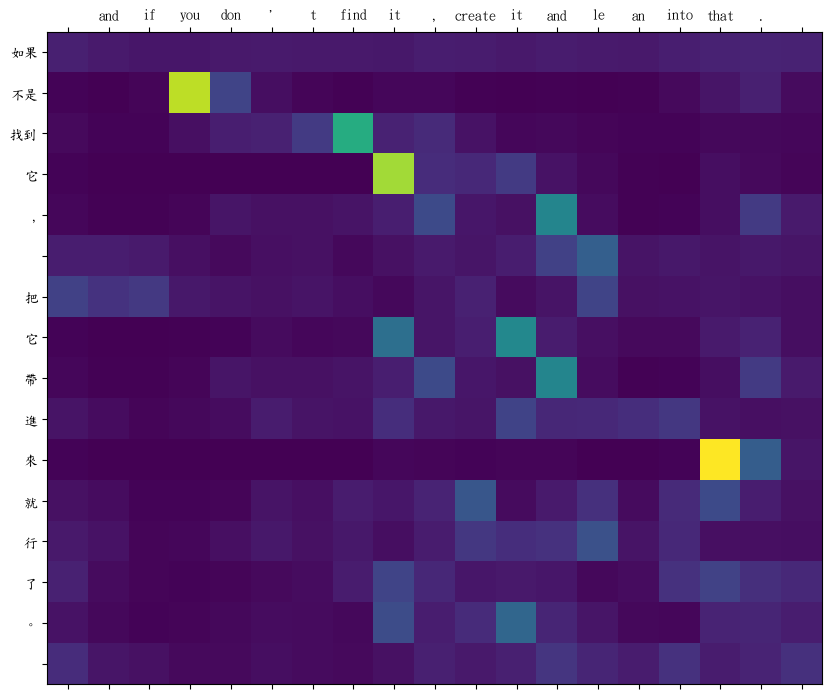

In [57]:
sentence="And if you don't find it, create it and lean into that."
translate(sentence)

Input: You spend more time with your parents.
Predicted translation: 你花到你的父母來 。
Predicted index: [156, 554, 65, 477, 2200, 67, 10, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


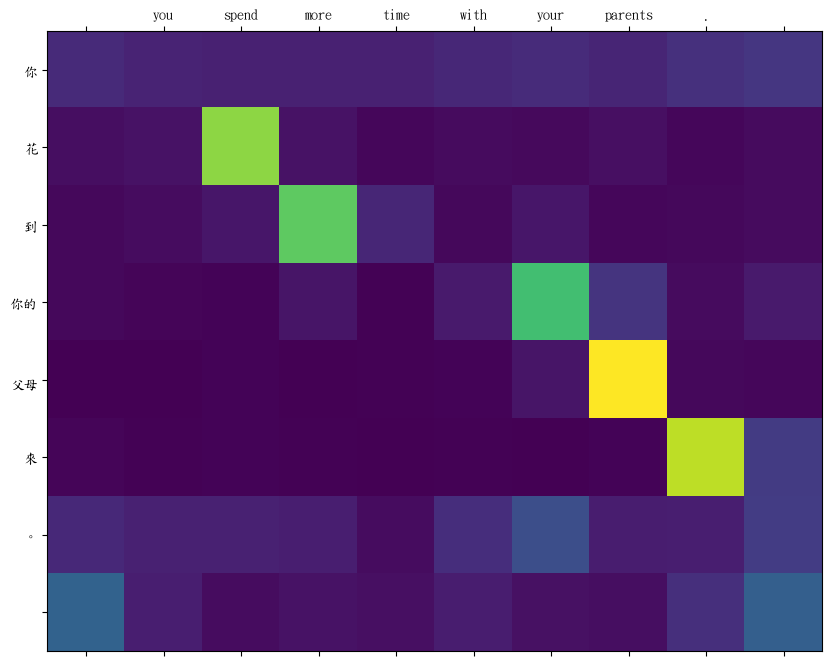

In [58]:
sentence="You spend more time with your parents."
translate(sentence)

Input: And I say that sincerely , partly because I need that .
Predicted translation: 我是這麼說 , 有部份是因為我需要的原因 。
Predicted index: [35, 26, 1090, 78, 4, 511, 2042, 1209, 37, 259, 8, 1168, 10, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


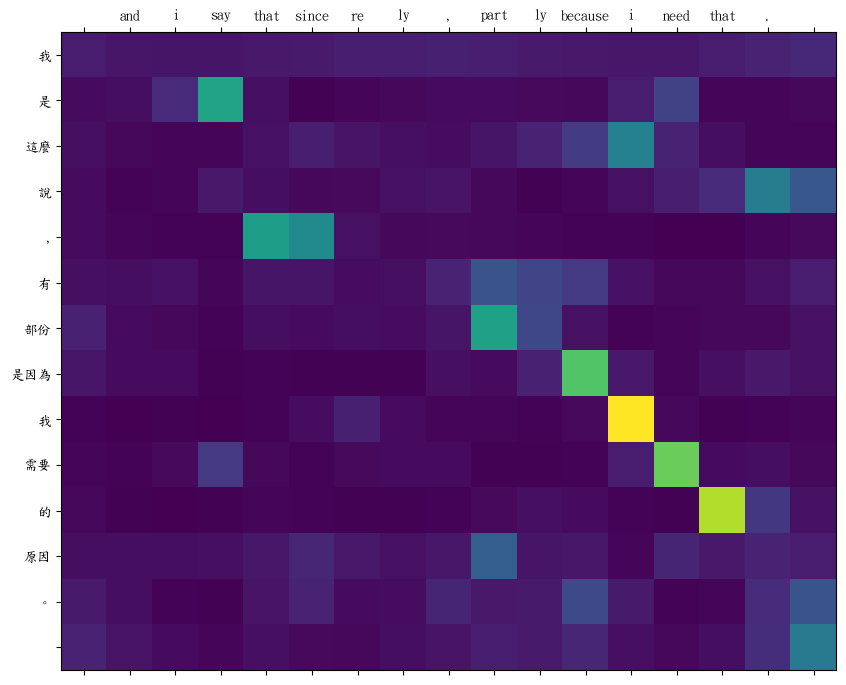

In [59]:
sentence="And I say that sincerely , partly because I need that ."
translate(sentence)

Input: Thank you .
Predicted translation: 謝謝 。
Predicted index: [946, 10, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


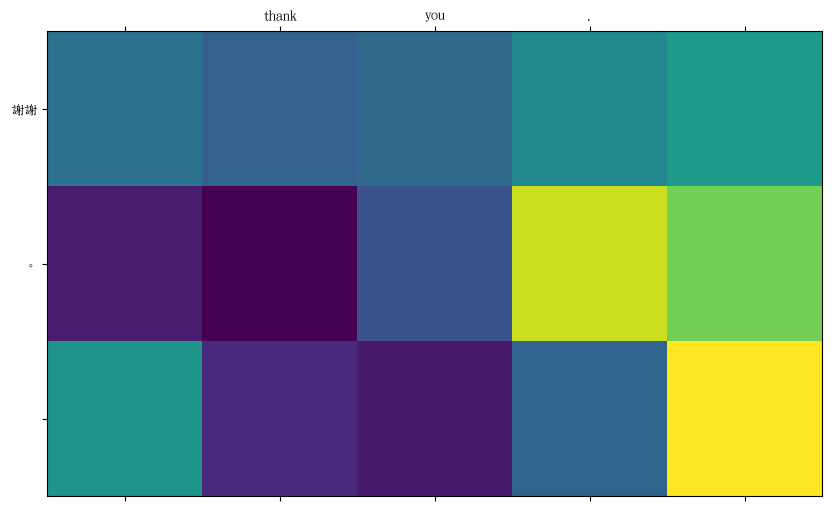

In [60]:
sentence="Thank you ."
translate(sentence)

Input: What’s the weather like today?
Predicted translation: 今天的氣溫是怎樣的
Predicted index: [5, 1013, 8, 583, 1661, 26, 2101, 8, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


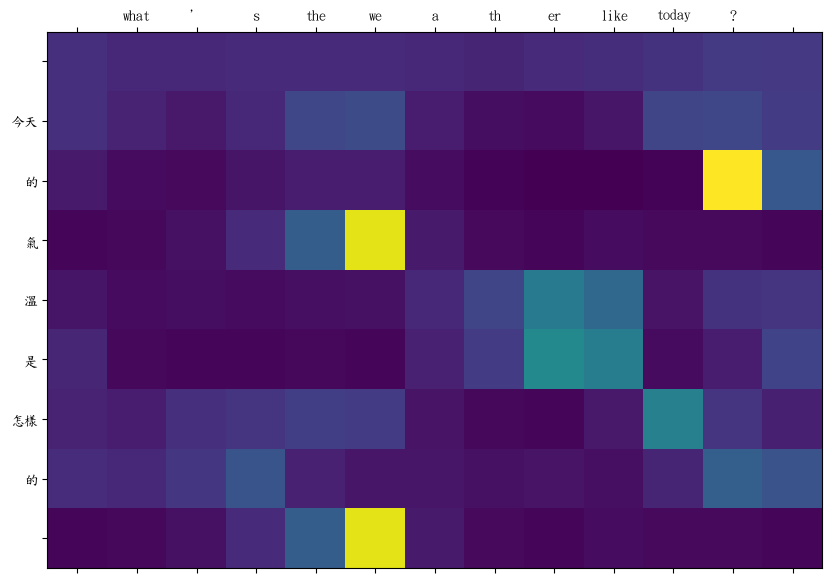

In [61]:
sentence="What’s the weather like today?"
translate(sentence)

Input: So what can you do ?
Predicted translation: 所以你能怎麼做 ?
Predicted index: [207, 71, 101, 688, 151, 32, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


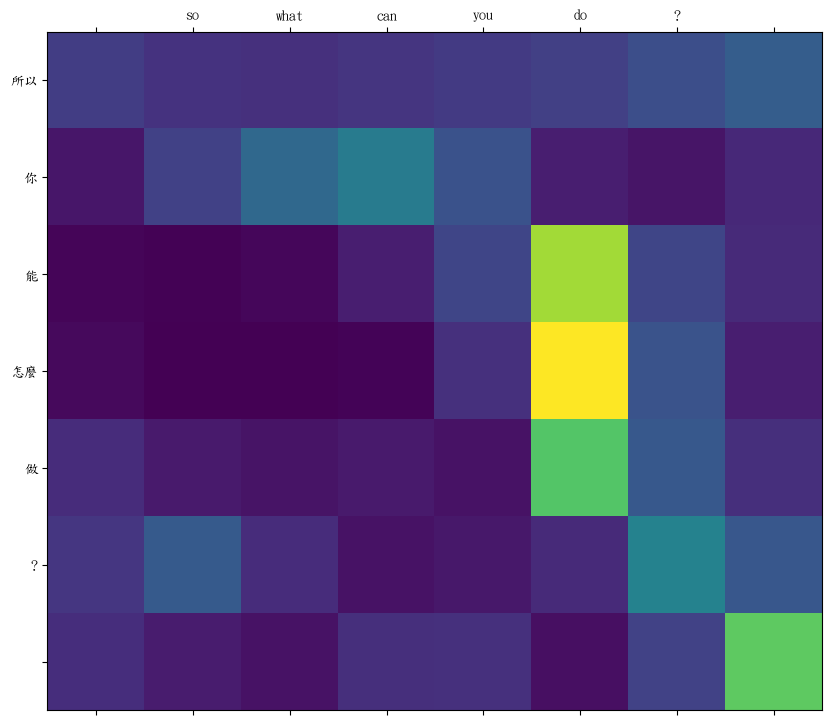

In [62]:
sentence="So what can you do ?"
translate(sentence)

Input: you love me.
Predicted translation: 你很愛我 。
Predicted index: [156, 88, 487, 37, 10, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


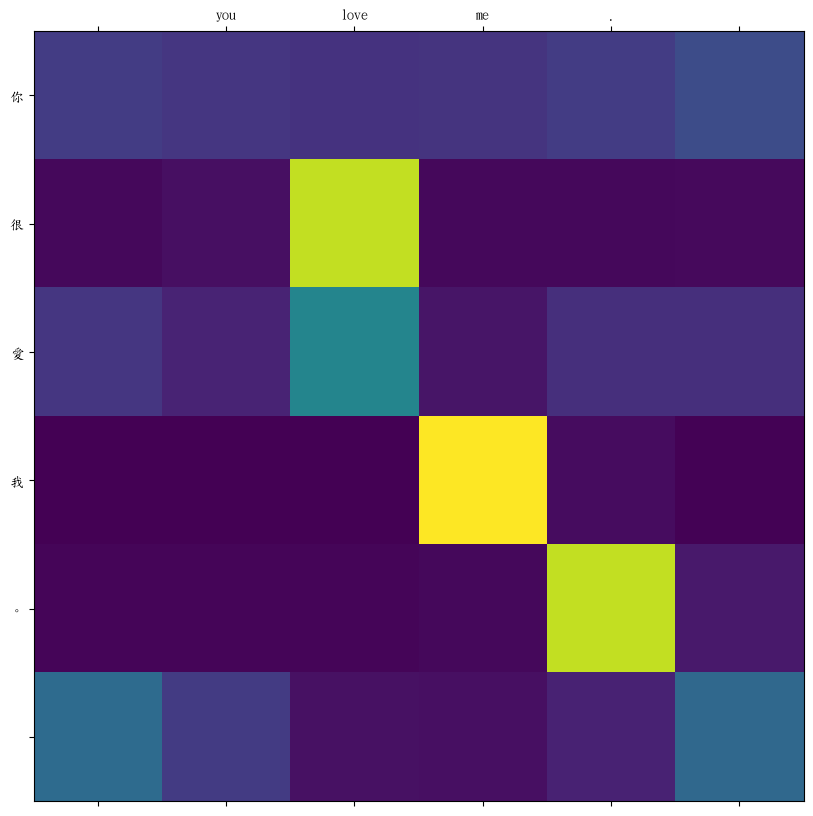

In [63]:
sentence="you love me."
translate(sentence)

Input: It's very difficult.
Predicted translation: 這真的很困難 。
Predicted index: [122, 475, 88, 2320, 10, 2]


C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=fontset)
C:\Users\Admin\AppData\Local\Temp\ipykernel_74532\3075567793.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontset)


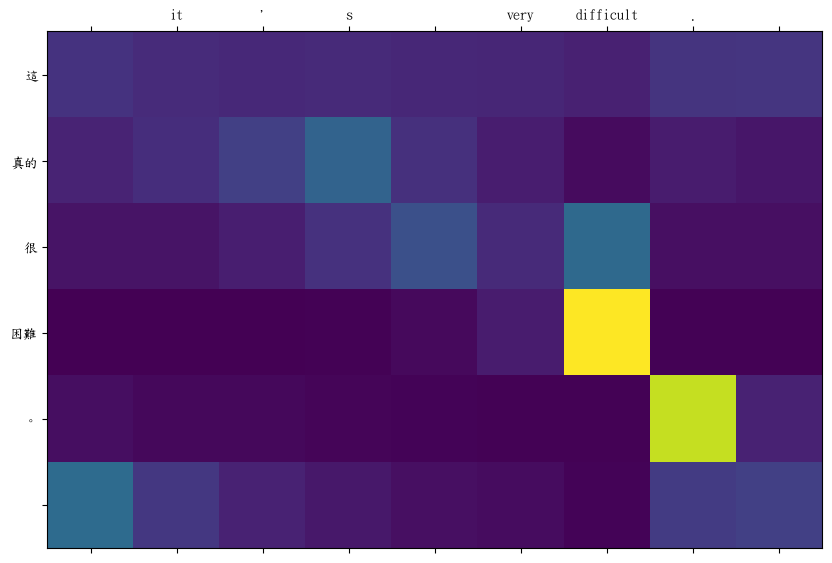

In [64]:
sentence="It's very difficult."
translate(sentence)